In [167]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.constants import N_A
import math
import seaborn as sns

In [168]:
def single_cell_binding_model(t, z, Atot, r1tot, r2tot, k1, k2, 
                      q1, q2, koff, qoff):
    
    A00 = Atot - z[0] - z[1] - z[2]
    r1 = r1tot - z[0] - z[2]
    r2 = r2tot - z[1] - z[2]

    dA10 = k1*A00*r1 - koff*z[0] - q2*z[0]*r2 + qoff*z[2]
    dA01 = q1*A00*r2 - qoff*z[1] - k2*z[1]*r1 + koff*z[2]
    dA11 = q2*z[0]*r2 + k2*z[1]*r1 - (qoff + koff)*z[2]

    dz = [dA10, dA01, dA11]

    return dz

In [169]:
A0s = np.geomspace(1e-13, 5e-5, 200)
Target_cell_number = 2e5
well_size = 125e-6
t_end = 60*60*4
t = np.geomspace(1e-10, t_end, 200)
t_span = [1e-10, t_end]
z0 = np.asarray([0, 0, 0])
tumour_cell_radius = 8e-6
sigma = well_size*N_A/Target_cell_number

D1 = 5e-14
D2 = 6e-12
k2 = D1/(2*math.pi*(tumour_cell_radius**2))
q2 = D2/(2*math.pi*(tumour_cell_radius**2))

r1tot = 1e2
r2tot = 1e5

CD4_variants = ['VKY94A', 'VKY92A', 'VHY99A/VKY94A']
CD4_on_rates = [2.2e5, 1.2e5, 2.7e5]
CD4_off_rates = [3.1e-4, 1.8e-3, 2.1e-2]

PD1_variants = ['ADI-28015', 'ADI-28008', 'ADI-22366']
PD1_affinities = [1.43e-9, 12.8e-9, 91.8e-9]
PD1_on_rates = [2e5, 2e5, 2e5]
PD1_off_rates = [PD1_affinities[i]*PD1_on_rates[i] for i in range(len(PD1_on_rates))]

combinations = [['VHY99A/VKY94A', 'ADI-22366'],
                ['VKY92A', 'ADI-28008'], 
                ['VKY94A', 'ADI-28015'],
                ['VHY99A/VKY94A', 'ADI-28015'],
                ['VKY94A', 'ADI-22366']]

In [170]:
r_occupancy_pd1 = np.zeros((len(combinations), len(A0s)))
r_occupancy_cd4 = np.zeros((len(combinations), len(A0s)))
bound_ab = np.zeros((len(combinations), len(A0s)))

for i, clones in enumerate(combinations):
    print(clones)
    cd4 = clones[0]
    pd1 = clones[1]
    id1 = CD4_variants.index(cd4)
    id2 = PD1_variants.index(pd1)
    
    kon = CD4_on_rates[id1]
    k1 = kon/sigma
    qon = PD1_on_rates[id2]
    q1 = qon/sigma
    koff = CD4_off_rates[id1]
    qoff = PD1_off_rates[id2]

    for j, Ainit in enumerate(A0s):
        
        Atot = Ainit*sigma
        z = solve_ivp(single_cell_binding_model, t_span, z0, method='Radau', t_eval=t, args=(Atot, r1tot, r2tot, k1, k2, 
                        q1, q2, koff, qoff))
    
        A10 = z.y[0]
        A01 = z.y[1]
        A11 = z.y[2]

        r_occupancy_cd4[i, j] = (A10[-1] + A11[-1])/r1tot
        r_occupancy_pd1[i, j] = (A01[-1] + A11[-1])/r2tot
        bound_ab[i, j] = (A10[-1] + A01[-1] + A11[-1])/(r1tot + r2tot)


['VHY99A/VKY94A', 'ADI-22366']
['VKY92A', 'ADI-28008']
['VKY94A', 'ADI-28015']
['VHY99A/VKY94A', 'ADI-28015']
['VKY94A', 'ADI-22366']


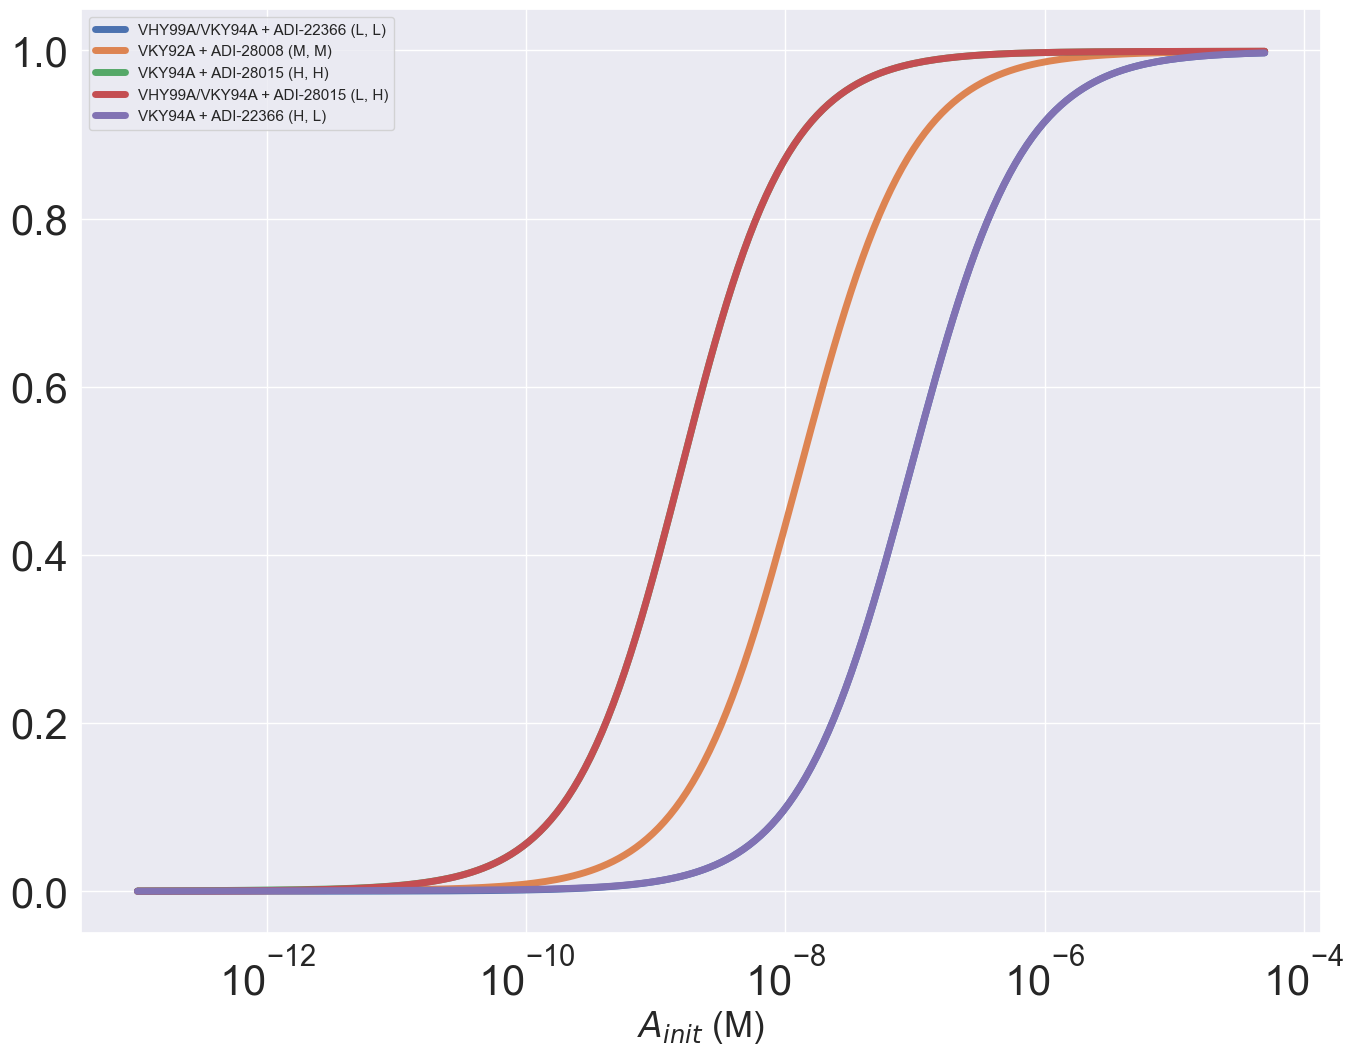

In [171]:
sns.set_context('talk')
sns.set_theme()
clone_affin_labels = ['(L, L)', '(M, M)', '(H, H)', '(L, H)', '(H, L)']
fig, ax = plt.subplots(figsize=(16, 12))
for i, clones in enumerate(combinations):
    label = clones[0] + ' + ' + clones[1] + ' ' + clone_affin_labels[i]
    ax.semilogx(A0s, bound_ab[i, :], label=label, lw=5)

ax.tick_params(labelsize=30)
ax.legend(loc='best')
ax.set_xlabel(r'$A_{init}$ (M)', fontsize=25)
plt.show()

In [172]:
def selectivity_model(t, z, Atot, r1tot, r2tot, s1tot, s2tot, k1, k2, 
                      q1, q2, p1, t1, koff, qoff, poff, toff):
    
    A00 = Atot - z[0] - z[1] - z[2] - z[3] - z[4]
    r1 = r1tot - z[0] - z[2]
    r2 = r2tot - z[1] - z[2]
    s1 = s1tot - z[3]
    s2 = s2tot - z[4]

    dA10 = k1*A00*r1 - koff*z[0] - q2*z[0]*r2 + qoff*z[2]
    dA01 = q1*A00*r2 - qoff*z[1] - k2*z[1]*r1 + koff*z[2]
    dA11 = q2*z[0]*r2 + k2*z[1]*r1 - (qoff + koff)*z[2]
    dA10_nt = p1*A00*s1 - poff*z[3]
    dA01_nt = t1*A00*s2 -toff*z[4]

    dz = [dA10, dA01, dA11, dA10_nt, dA01_nt]

    return dz

In [173]:
Target_cell_number = 2e5
Non_target_cell_number_1 = 2e6
Non_target_cell_number_2 = 2e6
z0 = np.asarray([0, 0, 0, 0, 0])
tumour_cell_radius = 8e-6
sigma = well_size*N_A

r1tot = 1e3
r1tot = r1tot*Target_cell_number
r2tot = 1e4
r2tot = r2tot*Target_cell_number
s1tot = 1e3
s1tot = s1tot*Non_target_cell_number_1
s2tot = 1e3
s2tot = s2tot*Non_target_cell_number_2


D1 = 1e-14
D2 = 1e-14
k2 = D1/(2*math.pi*(tumour_cell_radius**2)*Target_cell_number)
q2 = D2/(2*math.pi*(tumour_cell_radius**2)*Target_cell_number)

In [174]:
selectivity = np.zeros((len(combinations), len(A0s)))

for i, clones in enumerate(combinations):
    print(clones)
    cd4 = clones[0]
    pd1 = clones[1]
    id1 = CD4_variants.index(cd4)
    id2 = PD1_variants.index(pd1)
    
    kon = CD4_on_rates[id1]
    k1 = kon/sigma
    p1 = k1
    qon = PD1_on_rates[id2]
    q1 = qon/sigma
    t1 = q1
    koff = CD4_off_rates[id1]
    poff = koff
    qoff = PD1_off_rates[id2]
    toff = qoff

    for j, Ainit in enumerate(A0s):
        
        Atot = Ainit*sigma
        z = solve_ivp(selectivity_model, t_span, z0, method='Radau', t_eval=t, args=(Atot, r1tot, r2tot, s1tot, s2tot, k1, k2, 
                        q1, q2, p1, t1, koff, qoff, poff, toff))
    
        A10 = z.y[0]
        A01 = z.y[1]
        A11 = z.y[2]
        A10_nt = z.y[3]
        A01_nt = z.y[4]


        selectivity[i, j] = (A10[-1] + A11[-1] + A01[-1])/(A10[-1] + A11[-1] + A01[-1] + A10_nt[-1] + A01_nt[-1])
        


['VHY99A/VKY94A', 'ADI-22366']
['VKY92A', 'ADI-28008']
['VKY94A', 'ADI-28015']
['VHY99A/VKY94A', 'ADI-28015']
['VKY94A', 'ADI-22366']


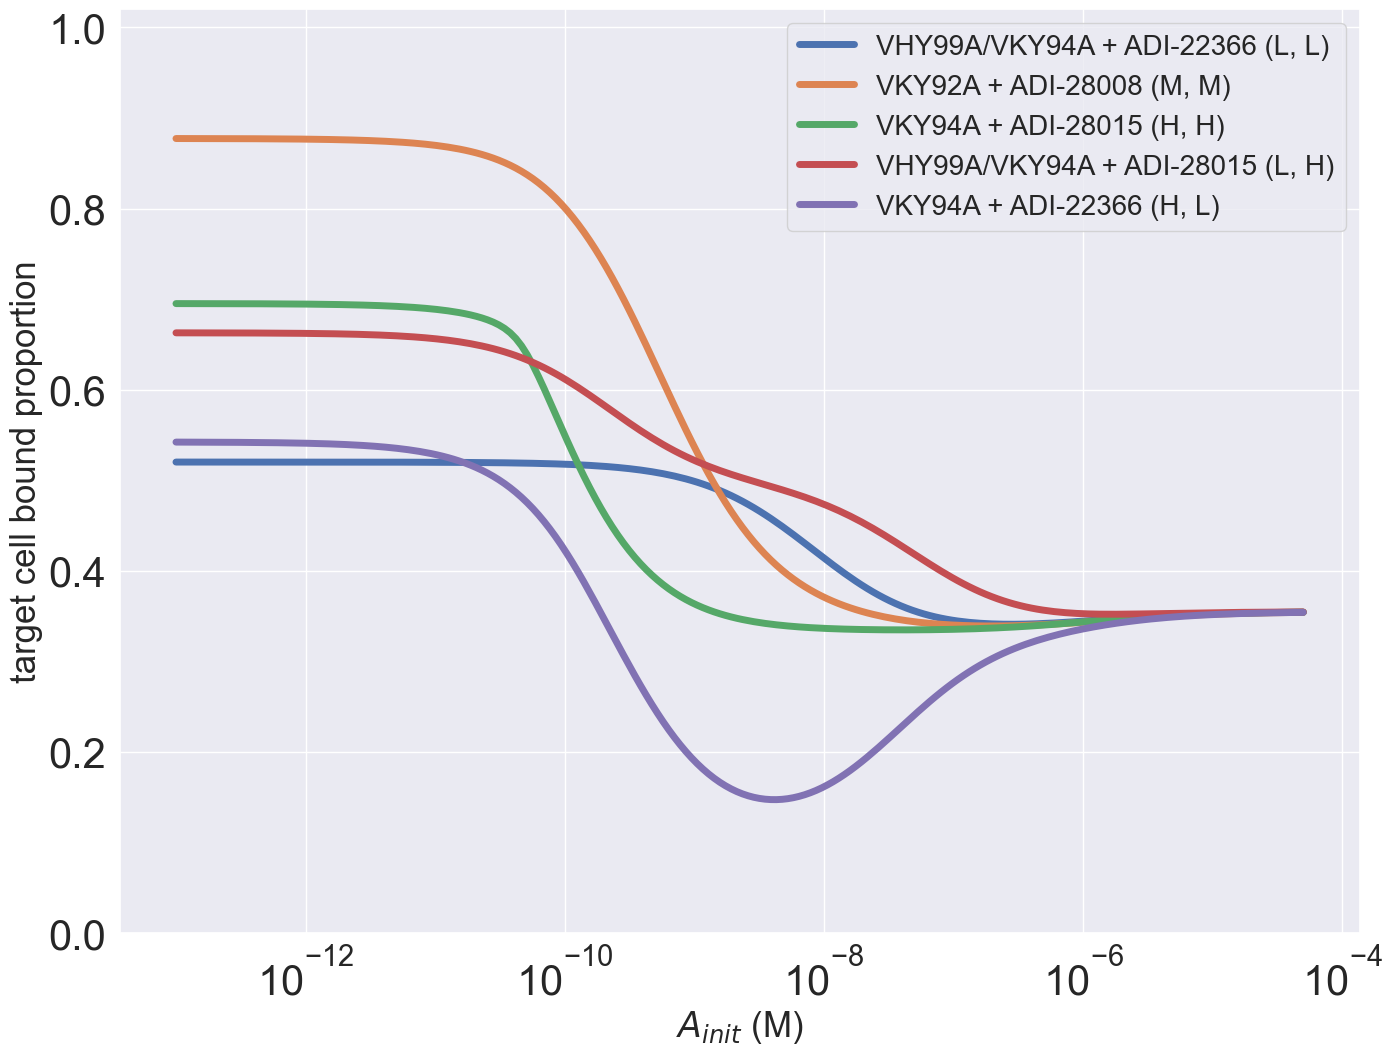

In [175]:
clone_affin_labels = ['(L, L)', '(M, M)', '(H, H)', '(L, H)', '(H, L)']
fig, ax = plt.subplots(figsize=(16, 12))
for i, clones in enumerate(combinations):
    label = clones[0] + ' + ' + clones[1] + ' ' + clone_affin_labels[i]
    ax.semilogx(A0s, selectivity[i, :], label=label, lw=5)

ax.tick_params(labelsize=30)
ax.legend(loc='best', fontsize=20)
ax.set_xlabel(r'$A_{init}$ (M)', fontsize=25)
ax.set_ylabel(r'target cell bound proportion', fontsize =25)
ax.set_ylim(0, 1.02)
plt.show()